Level Up! Now on Level 2
Episode 1: Total Reward = 140, Steps = 5
Level Up! Now on Level 3
Episode 2: Total Reward = 110, Steps = 16
Level Up! Now on Level 4
Episode 3: Total Reward = 120, Steps = 7
GAME OVER! Total Score: 100
Episode 4: Total Reward = 100, Steps = 22


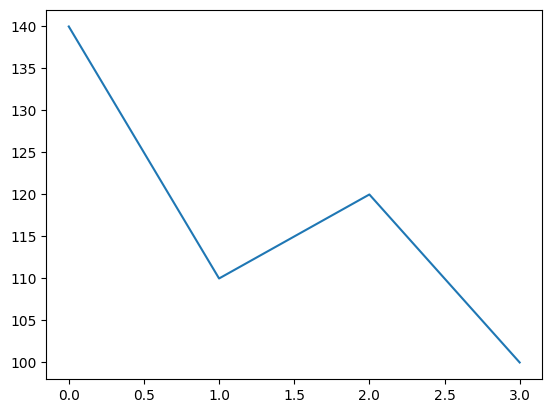

In [ ]:
import pygame
import numpy as np
import random
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import pickle


pygame.init()


GRID_SIZE = 10
WINDOW_SIZE = 600
CELL_SIZE = WINDOW_SIZE // GRID_SIZE
FPS = 30
MAX_HITS = 3


WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
PLAYER_COLOR = (0, 128, 255)
ENEMY_COLOR = (255, 0, 0)
BULLET_COLOR = (0, 255, 0)

# Neural Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Q
state_dim = 4
action_dim = 3
q_network_1 = QNetwork(state_dim, action_dim)
q_network_2 = QNetwork(state_dim, action_dim)
optimizer_1 = optim.Adam(q_network_1.parameters(), lr=0.001)
optimizer_2 = optim.Adam(q_network_2.parameters(), lr=0.001)


BUFFER_SIZE = 500
BATCH_SIZE = 32
experience_buffer = deque(maxlen=BUFFER_SIZE)


GAMMA = 0.95
EPSILON = 1.0
MIN_EPSILON = 0.3
EPSILON_DECAY = 0.995
EPISODES = 500
MAX_STEPS = 100


HIT_REWARD = 100
ALIGNMENT_REWARD = 10
MOVE_PENALTY = 0
MISS_PENALTY = -1
HIT_PENALTY = -20
GAME_OVER_PENALTY = -50


screen = pygame.display.set_mode((WINDOW_SIZE, WINDOW_SIZE))
pygame.display.set_caption('Q-Learning Shooter')
clock = pygame.time.Clock()


BASE_SCORE = 50
INCREMENT = 25
MAX_LEVELS = 10
difficulty_multiplier = 1.0

def get_level_threshold(level):
    return (BASE_SCORE + level * INCREMENT) * difficulty_multiplier

def reset_game():
    return [GRID_SIZE // 2, GRID_SIZE - 1], [random.randint(0, GRID_SIZE - 1), 0], []

def choose_action(state, q_net, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, action_dim - 1)
    state_tensor = torch.tensor(state, dtype=torch.float32)
    with torch.no_grad():
        return torch.argmax(q_net(state_tensor)).item()

def train_q_network(q_net, target_net, optimizer, batch):
    states, actions, rewards, next_states, dones = zip(*batch)
    states = torch.tensor(states, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.long)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        next_q_values = target_net(next_states).max(1)[0]
        targets = rewards + GAMMA * next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def draw_game(player_pos, enemy_pos, bullets, score, level, hits):
    screen.fill(BLACK)
    pygame.draw.rect(screen, PLAYER_COLOR, (player_pos[0] * CELL_SIZE, player_pos[1] * CELL_SIZE, CELL_SIZE, CELL_SIZE))
    pygame.draw.rect(screen, ENEMY_COLOR, (enemy_pos[0] * CELL_SIZE, enemy_pos[1] * CELL_SIZE, CELL_SIZE, CELL_SIZE))
    for bullet in bullets:
        pygame.draw.rect(screen, BULLET_COLOR, (bullet[0] * CELL_SIZE, bullet[1] * CELL_SIZE, CELL_SIZE, CELL_SIZE))
    font = pygame.font.Font(None, 36)
    screen.blit(font.render(f"Score: {score}", True, WHITE), (10, 10))
    screen.blit(font.render(f"Level: {level + 1}", True, WHITE), (10, 50))
    screen.blit(font.render(f"Hits Taken: {hits}/{MAX_HITS}", True, WHITE), (10, 90))


frames = []
rewards_per_episode = []
level = 0
score = 0
hits_taken = 0

for episode in range(EPISODES):
    player_pos, enemy_pos, bullets = reset_game()
    state = [player_pos[0], enemy_pos[0], enemy_pos[1], len(bullets)]
    total_reward = 0
    steps = 0
    game_over = False

    for step in range(MAX_STEPS):
        steps += 1
        action = choose_action(state, q_network_1, EPSILON)

        if action == 0 and player_pos[0] > 0:
            player_pos[0] -= 1
        elif action == 1 and player_pos[0] < GRID_SIZE - 1:
            player_pos[0] += 1
        elif action == 2:
            bullets.append([player_pos[0], player_pos[1] - 1])

        bullets = [[b[0], b[1] - 1] for b in bullets if b[1] >= 0]

        reward = MOVE_PENALTY
        if enemy_pos[1] < GRID_SIZE - 1:
            enemy_pos[1] += 1
        else:
            hits_taken += 1
            reward += HIT_PENALTY
            enemy_pos = [random.randint(0, GRID_SIZE - 1), 0]
            if hits_taken >= MAX_HITS:
                reward += GAME_OVER_PENALTY
                print(f"GAME OVER! Total Score: {score}")
                game_over = True
                break

        for bullet in bullets:
            if bullet[0] == enemy_pos[0] and bullet[1] == enemy_pos[1]:
                reward += HIT_REWARD
                score += HIT_REWARD
                enemy_pos = [random.randint(0, GRID_SIZE - 1), 0]
                bullets.remove(bullet)
                break

        if player_pos[0] == enemy_pos[0]:
            reward += ALIGNMENT_REWARD

        next_state = [player_pos[0], enemy_pos[0], enemy_pos[1], len(bullets)]
        experience_buffer.append((state, action, reward, next_state, hits_taken >= MAX_HITS))
        state = next_state
        total_reward += reward

        if len(experience_buffer) >= BATCH_SIZE:
            batch = random.sample(experience_buffer, BATCH_SIZE)
            train_q_network(q_network_1, q_network_2, optimizer_1, batch)

        if score >= get_level_threshold(level):
            level += 1
            if level >= MAX_LEVELS:
                print(f"AI COMPLETED ALL LEVELS! Final Score: {score}")
                game_over = True
                break
            print(f"Level Up! Now on Level {level + 1}")
            score = 0
            break

        draw_game(player_pos, enemy_pos, bullets, score, level, hits_taken)
        pygame.display.flip()

        frame = pygame.surfarray.array3d(screen)
        frame = np.rot90(frame, k=3)
        frame = np.fliplr(frame)
        frames.append(Image.fromarray(frame))

    EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)
    rewards_per_episode.append(total_reward)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}, Steps = {steps}")

    if game_over:
        break


if frames:
    frames[0].save('/mnt/q_learning_shooter.gif', save_all=True, append_images=frames[1:], duration=1000 // FPS, loop=0)

plt.plot(rewards_per_episode)
plt.show()

pygame.quit()
